In [20]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from pandas import DataFrame, Series
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

#import scikitplot
#from scikitplot.metrics import plot_roc_curve as prc
#from scikitplot.metrics import plot_lift_curve as plc
#from scikitplot.metrics import plot_cumulative_gain as pcg
#from sklearn.metrics import classification_report

# Ignore useless warnings
import warnings
warnings.filterwarnings("ignore")

In [95]:
path = 'C:/Users/quent/OneDrive/Documents/GitHub/projet-ia/'

test = pd.read_csv(path + "general_data.csv")
employe = pd.read_csv(path + "employee_survey_data.csv")
manager = pd.read_csv(path + "manager_survey_data.csv")
In = pd.read_csv(path + "in_time.csv")
Out = pd.read_csv(path + "out_time.csv")

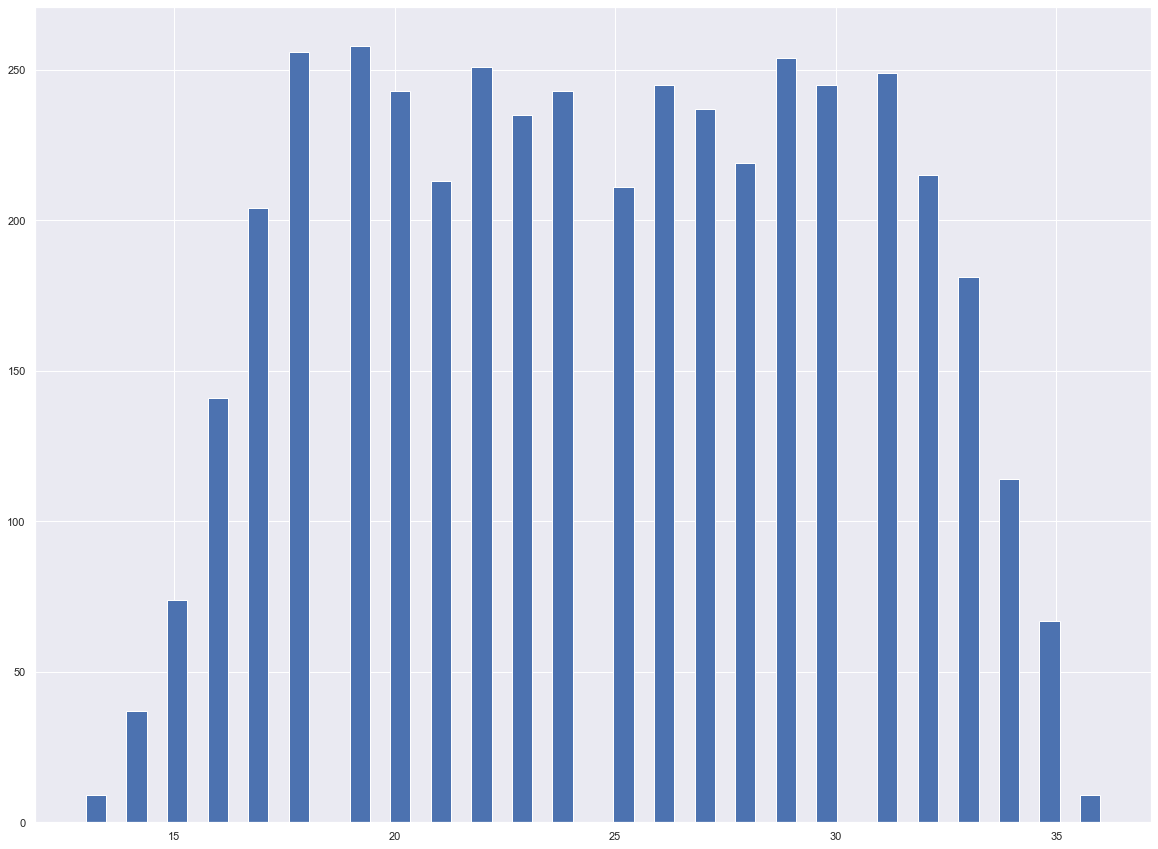

In [82]:
#In["mean"] = In.mean(axis = 1)
In.fillna(0, inplace=True)
vac = (In == 0).astype(int).sum(axis=1)
    
vac.hist(bins=50, figsize=(20,15))
plt.show()

In [90]:
In_h = pd.to_datetime(In, format='%Y-%M-%d %H' )

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

In [ ]:
On fusionne les trois tableaux CSV pour regrouper les données :

In [93]:
combined = test.merge(manager, how='right', on = 'EmployeeID')
combined_csv = combined.merge(employe, how='right', on = 'EmployeeID')
#On transforme tous les NA en 0
combined_csv.fillna(0, inplace=True)


combined_csv


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,10.0,5,3,0,2,3,3,4.0,1.0,3.0
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,10.0,2,3,0,2,2,3,4.0,4.0,3.0
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,5.0,4,4,1,2,3,4,1.0,3.0,3.0
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,10.0,2,9,7,8,2,3,4.0,1.0,3.0


In [18]:
test.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [70]:
test.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

In [71]:
test.astype(bool).sum(axis=0)

Age                        4410
Attrition                  4410
BusinessTravel             4410
Department                 4410
DistanceFromHome           4410
Education                  4410
EducationField             4410
EmployeeCount              4410
EmployeeID                 4410
Gender                     4410
JobLevel                   4410
JobRole                    4410
MaritalStatus              4410
MonthlyIncome              4410
NumCompaniesWorked         3824
Over18                     4410
PercentSalaryHike          4410
StandardHours              4410
StockOptionLevel           2517
TotalWorkingYears          4377
TrainingTimesLastYear      4248
YearsAtCompany             4278
YearsSinceLastPromotion    2667
YearsWithCurrManager       3621
dtype: int64

In [54]:
Cc['Attrition'].value_counts()

No     3699
Yes     711
Name: Attrition, dtype: int64

In [72]:
test['EmployeeCount'].value_counts()

1    4410
Name: EmployeeCount, dtype: int64

Ils sont tous à 1 donc osef

Après concertation, nous avons décidé de supprimer les données Over18, EmployeeCount, MaritalStatus et Gender. 

In [73]:
test = test.drop(columns=['EmployeeCount','Over18','Gender','MaritalStatus'])

Attrition : yes -> l'employé est parti en 2016 / no -> il est toujours dans l'entreprise

In [74]:
test['Attrition'].value_counts()

No     3699
Yes     711
Name: Attrition, dtype: int64

On cherche à savoir pourquoi ces 711 employés ont quitté l'entreprise, nous allons donc uniquement nous concentrer sur les données où l'Attrition est 'yes'.

In [75]:
test.set_index('Attrition')

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
Attrition,,,,,,,,,,,,,,,,,,,
No,51,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Healthcare Representative,131160,1.0,11,8,0,1.0,6,1,0,0
Yes,31,Travel_Frequently,Research & Development,10,1,Life Sciences,2,1,Research Scientist,41890,0.0,23,8,1,6.0,3,5,1,4
No,32,Travel_Frequently,Research & Development,17,4,Other,3,4,Sales Executive,193280,1.0,15,8,3,5.0,2,5,0,3
No,38,Non-Travel,Research & Development,2,5,Life Sciences,4,3,Human Resources,83210,3.0,11,8,3,13.0,5,8,7,5
No,32,Travel_Rarely,Research & Development,10,1,Medical,5,1,Sales Executive,23420,4.0,12,8,2,9.0,2,6,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
No,42,Travel_Rarely,Research & Development,5,4,Medical,4406,1,Research Scientist,60290,3.0,17,8,1,10.0,5,3,0,2
No,29,Travel_Rarely,Research & Development,2,4,Medical,4407,1,Laboratory Technician,26790,2.0,15,8,0,10.0,2,3,0,2
No,25,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,2,Sales Executive,37020,0.0,20,8,0,5.0,4,4,1,2


In [77]:
test_without_no = test.drop(test[test.Attrition == 'No'].index)
test_without_no

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,1,Research Scientist,41890,0.0,23,8,1,6.0,3,5,1,4
6,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,7,2,Sales Executive,58130,2.0,20,8,1,5.0,2,0,0,0
13,47,Yes,Non-Travel,Research & Development,1,1,Medical,14,1,Research Scientist,57620,1.0,11,8,2,10.0,4,10,9,9
28,44,Yes,Travel_Frequently,Research & Development,1,2,Medical,29,2,Research Scientist,103330,3.0,14,8,1,19.0,2,1,0,0
30,26,Yes,Travel_Rarely,Research & Development,4,3,Medical,31,3,Research Scientist,68540,2.0,11,8,0,5.0,5,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381,29,Yes,Travel_Rarely,Research & Development,7,1,Life Sciences,4382,1,Research Scientist,21800,1.0,21,8,0,4.0,2,4,0,1
4386,33,Yes,Travel_Rarely,Sales,11,4,Marketing,4387,1,Research Scientist,71400,5.0,21,8,0,8.0,2,5,0,4
4388,33,Yes,Travel_Rarely,Sales,1,3,Life Sciences,4389,2,Manager,51470,7.0,11,8,0,13.0,2,9,1,7
4391,32,Yes,Travel_Rarely,Sales,23,1,Life Sciences,4392,3,Healthcare Representative,24680,0.0,11,8,0,4.0,2,3,1,2


Afin de pouvoir étudier d'éventuelles corrélations, nous allons, dans un DataFrame temporaire, numériser certaines valeurs afin de n'avoir que des valeurs numériques.

In [89]:
test_without_no['BusinessTravel'].value_counts()

Travel_Rarely        468
Travel_Frequently    207
Non-Travel            36
Name: BusinessTravel, dtype: int64

In [90]:
test_without_no['Department'].value_counts()

Research & Development    453
Sales                     201
Human Resources            57
Name: Department, dtype: int64

In [91]:
test_without_no['EducationField'].value_counts()

Life Sciences       303
Medical             225
Marketing            75
Technical Degree     45
Human Resources      33
Other                30
Name: EducationField, dtype: int64

In [92]:
test_without_no['JobRole'].value_counts()

Sales Executive              165
Research Scientist           159
Laboratory Technician        126
Research Director             57
Healthcare Representative     57
Manufacturing Director        48
Manager                       42
Sales Representative          36
Human Resources               21
Name: JobRole, dtype: int64

In [102]:
temp = test_without_no
temp

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,31,Travel_Frequently,Research & Development,10,1,Life Sciences,2,1,Research Scientist,41890,0.0,23,8,1,6.0,3,5,1,4
6,28,Travel_Rarely,Research & Development,11,2,Medical,7,2,Sales Executive,58130,2.0,20,8,1,5.0,2,0,0,0
13,47,Non-Travel,Research & Development,1,1,Medical,14,1,Research Scientist,57620,1.0,11,8,2,10.0,4,10,9,9
28,44,Travel_Frequently,Research & Development,1,2,Medical,29,2,Research Scientist,103330,3.0,14,8,1,19.0,2,1,0,0
30,26,Travel_Rarely,Research & Development,4,3,Medical,31,3,Research Scientist,68540,2.0,11,8,0,5.0,5,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381,29,Travel_Rarely,Research & Development,7,1,Life Sciences,4382,1,Research Scientist,21800,1.0,21,8,0,4.0,2,4,0,1
4386,33,Travel_Rarely,Sales,11,4,Marketing,4387,1,Research Scientist,71400,5.0,21,8,0,8.0,2,5,0,4
4388,33,Travel_Rarely,Sales,1,3,Life Sciences,4389,2,Manager,51470,7.0,11,8,0,13.0,2,9,1,7
4391,32,Travel_Rarely,Sales,23,1,Life Sciences,4392,3,Healthcare Representative,24680,0.0,11,8,0,4.0,2,3,1,2


In [108]:
temp.reset_index(drop=True, inplace=True)
temp

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,31,Travel_Frequently,Research & Development,10,1,Life Sciences,2,1,Research Scientist,41890,0.0,23,8,1,6.0,3,5,1,4
1,28,Travel_Rarely,Research & Development,11,2,Medical,7,2,Sales Executive,58130,2.0,20,8,1,5.0,2,0,0,0
2,47,Non-Travel,Research & Development,1,1,Medical,14,1,Research Scientist,57620,1.0,11,8,2,10.0,4,10,9,9
3,44,Travel_Frequently,Research & Development,1,2,Medical,29,2,Research Scientist,103330,3.0,14,8,1,19.0,2,1,0,0
4,26,Travel_Rarely,Research & Development,4,3,Medical,31,3,Research Scientist,68540,2.0,11,8,0,5.0,5,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,29,Travel_Rarely,Research & Development,7,1,Life Sciences,4382,1,Research Scientist,21800,1.0,21,8,0,4.0,2,4,0,1
707,33,Travel_Rarely,Sales,11,4,Marketing,4387,1,Research Scientist,71400,5.0,21,8,0,8.0,2,5,0,4
708,33,Travel_Rarely,Sales,1,3,Life Sciences,4389,2,Manager,51470,7.0,11,8,0,13.0,2,9,1,7
709,32,Travel_Rarely,Sales,23,1,Life Sciences,4392,3,Healthcare Representative,24680,0.0,11,8,0,4.0,2,3,1,2


In [109]:
for i in range (0, temp.shape[0]):
    if temp['BusinessTravel'][i] == 'Non-Travel':
        temp['BusinessTravel'][i] = 0
    elif temp['BusinessTravel'][i] == 'Travel_Rarely':
        temp['BusinessTravel'][i] = 1
    elif temp['BusinessTravel'][i] == 'Travel_Frequently':
        temp['BusinessTravel'][i] = 2

In [110]:
for i in range (0, temp.shape[0]):
    if temp['Department'][i] == 'Human Resources':
        temp['Department'][i] = 0
    elif temp['Department'][i] == 'Sales':
        temp['Department'][i] = 1
    elif temp['Department'][i] == 'Research & Development':
        temp['Department'][i] = 2

In [111]:
for i in range (0, temp.shape[0]):
    if temp['EducationField'][i] == 'Other':
        temp['EducationField'][i] = 0
    elif temp['EducationField'][i] == 'Human Resources':
        temp['EducationField'][i] = 1
    elif temp['EducationField'][i] == 'Technical Degree':
        temp['EducationField'][i] = 2
    elif temp['EducationField'][i] == 'Marketing':
        temp['EducationField'][i] = 3
    elif temp['EducationField'][i] == 'Medical':
        temp['EducationField'][i] = 4
    elif temp['EducationField'][i] == 'Life Sciences':
        temp['EducationField'][i] = 5

In [112]:
for i in range (0, temp.shape[0]):
    if temp['JobRole'][i] == 'Human Resources':
        temp['JobRole'][i] = 0
    elif temp['JobRole'][i] == 'Sales Representative':
        temp['JobRole'][i] = 1
    elif temp['JobRole'][i] == 'Manager':
        temp['JobRole'][i] = 2
    elif temp['JobRole'][i] == 'Manufacturing Director':
        temp['JobRole'][i] = 3
    elif temp['JobRole'][i] == 'Healthcare Representative':
        temp['JobRole'][i] = 4
    elif temp['JobRole'][i] == 'Research Director':
        temp['JobRole'][i] = 5
    elif temp['JobRole'][i] == 'Laboratory Technician':
        temp['JobRole'][i] = 6
    elif temp['JobRole'][i] == 'Research Scientist':
        temp['JobRole'][i] = 7
    elif temp['JobRole'][i] == 'Sales Executive':
        temp['JobRole'][i] = 8

In [114]:
temp

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,31,2,2,10,1,5,2,1,7,41890,0.0,23,8,1,6.0,3,5,1,4
1,28,1,2,11,2,4,7,2,8,58130,2.0,20,8,1,5.0,2,0,0,0
2,47,0,2,1,1,4,14,1,7,57620,1.0,11,8,2,10.0,4,10,9,9
3,44,2,2,1,2,4,29,2,7,103330,3.0,14,8,1,19.0,2,1,0,0
4,26,1,2,4,3,4,31,3,7,68540,2.0,11,8,0,5.0,5,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,29,1,2,7,1,5,4382,1,7,21800,1.0,21,8,0,4.0,2,4,0,1
707,33,1,1,11,4,3,4387,1,7,71400,5.0,21,8,0,8.0,2,5,0,4
708,33,1,1,1,3,5,4389,2,2,51470,7.0,11,8,0,13.0,2,9,1,7
709,32,1,1,23,1,5,4392,3,4,24680,0.0,11,8,0,4.0,2,3,1,2


In [127]:
# Les valeures numériques changées précédemment sont considérées comme des objets et non des valeures numériques
# On utilise to_numeric afin de changer cela et de pouvoir les visulaiser dans des tableaux/graphes.
temp['BusinessTravel']=pd.to_numeric(temp['BusinessTravel'])
temp['Department']=pd.to_numeric(temp['Department'])
temp['EducationField']=pd.to_numeric(temp['EducationField'])
temp['JobRole']=pd.to_numeric(temp['JobRole'])
print(temp.dtypes)

Age                          int64
BusinessTravel               int64
Department                   int64
DistanceFromHome             int64
Education                    int64
EducationField               int64
EmployeeID                   int64
JobLevel                     int64
JobRole                      int64
MonthlyIncome                int64
NumCompaniesWorked         float64
PercentSalaryHike            int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
YearsSinceLastPromotion      int64
YearsWithCurrManager         int64
dtype: object


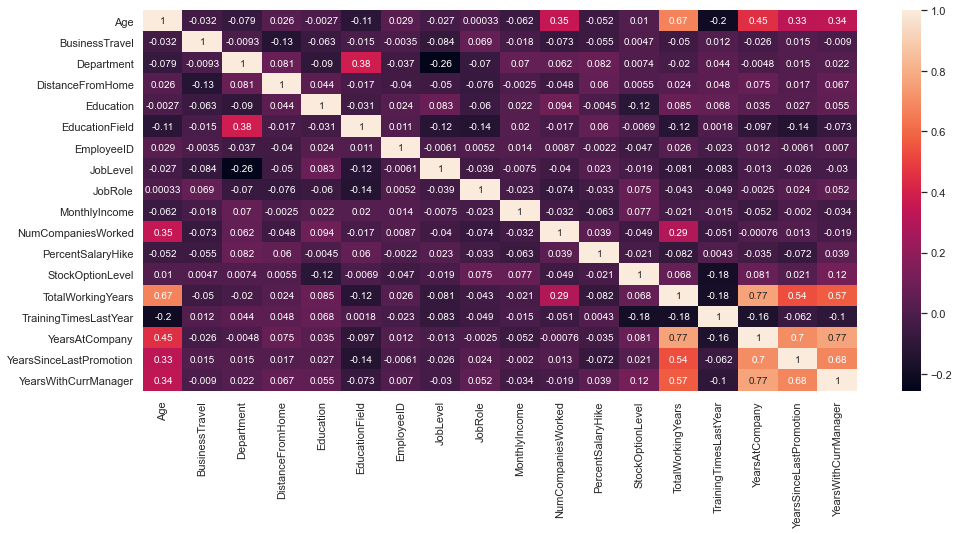

In [128]:
corr_cols = temp[['Age','BusinessTravel','Department','DistanceFromHome',
                     'Education','EducationField','EmployeeID','JobLevel',
                     'JobRole','MonthlyIncome','NumCompaniesWorked','PercentSalaryHike',
                     'StockOptionLevel','TotalWorkingYears','TrainingTimesLastYear',
                     'YearsAtCompany','YearsSinceLastPromotion','YearsWithCurrManager']]
corr = corr_cols.corr()
plt.figure(figsize=(16,7))
sns.heatmap(corr, annot=True)
plt.show()

Faisons quelques graphes afin de voir si quoi que ce soit est notable visuellement.

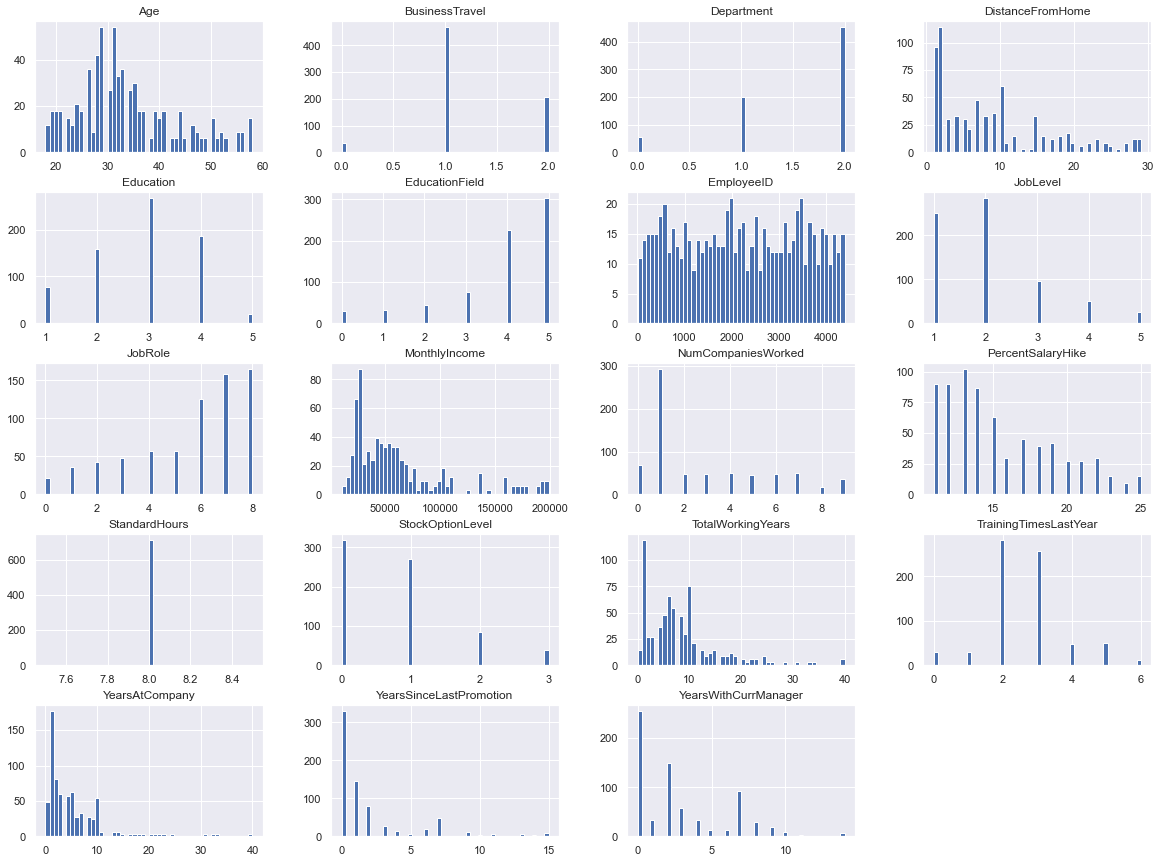

In [129]:
temp.hist(bins=50, figsize=(20,15))
plt.show()

In [82]:
test_without_no['Department'].value_counts()

Research & Development    453
Sales                     201
Human Resources            57
Name: Department, dtype: int64

In [83]:
test_RandD = test_without_no[test_without_no.Department == 'Research & Development']
test_RandD

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,1,Research Scientist,41890,0.0,23,8,1,6.0,3,5,1,4
6,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,7,2,Sales Executive,58130,2.0,20,8,1,5.0,2,0,0,0
13,47,Yes,Non-Travel,Research & Development,1,1,Medical,14,1,Research Scientist,57620,1.0,11,8,2,10.0,4,10,9,9
28,44,Yes,Travel_Frequently,Research & Development,1,2,Medical,29,2,Research Scientist,103330,3.0,14,8,1,19.0,2,1,0,0
30,26,Yes,Travel_Rarely,Research & Development,4,3,Medical,31,3,Research Scientist,68540,2.0,11,8,0,5.0,5,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4344,35,Yes,Travel_Rarely,Research & Development,2,4,Life Sciences,4345,2,Research Director,108830,3.0,12,8,0,8.0,3,1,0,1
4362,32,Yes,Travel_Rarely,Research & Development,5,3,Medical,4363,1,Healthcare Representative,34770,1.0,11,8,0,14.0,2,14,9,8
4366,30,Yes,Travel_Rarely,Research & Development,10,4,Life Sciences,4367,2,Research Scientist,55620,5.0,13,8,0,8.0,3,5,0,4
4369,29,Yes,Travel_Rarely,Research & Development,2,3,Life Sciences,4370,1,Sales Executive,49780,0.0,13,8,0,7.0,3,6,1,5


In [84]:
test_Sales = test_without_no[test_without_no.Department == 'Sales']
test_Sales

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
124,26,Yes,Travel_Frequently,Sales,14,3,Life Sciences,125,2,Manager,75100,0.0,18,8,3,7.0,3,6,0,4
127,30,Yes,Travel_Frequently,Sales,3,2,Marketing,128,3,Research Scientist,11290,9.0,19,8,0,3.0,2,1,0,0
178,33,Yes,Travel_Rarely,Sales,5,4,Marketing,179,2,Research Director,66520,7.0,25,8,0,8.0,5,4,1,3
182,34,Yes,Travel_Frequently,Sales,17,1,Marketing,183,1,Research Director,20010,9.0,22,8,1,11.0,5,3,0,2
205,26,Yes,Travel_Rarely,Sales,1,3,Marketing,206,2,Manufacturing Director,24260,1.0,22,8,0,1.0,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4368,30,Yes,Travel_Frequently,Sales,3,2,Medical,4369,2,Healthcare Representative,28620,5.0,14,8,0,9.0,2,6,0,1
4386,33,Yes,Travel_Rarely,Sales,11,4,Marketing,4387,1,Research Scientist,71400,5.0,21,8,0,8.0,2,5,0,4
4388,33,Yes,Travel_Rarely,Sales,1,3,Life Sciences,4389,2,Manager,51470,7.0,11,8,0,13.0,2,9,1,7
4391,32,Yes,Travel_Rarely,Sales,23,1,Life Sciences,4392,3,Healthcare Representative,24680,0.0,11,8,0,4.0,2,3,1,2


In [85]:
test_HR = test_without_no[test_without_no.Department == 'Human Resources']
test_HR

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
105,33,Yes,Travel_Rarely,Human Resources,28,2,Human Resources,106,5,Manager,55610,1.0,21,8,1,1.0,3,1,0,0
112,21,Yes,Travel_Rarely,Human Resources,10,2,Human Resources,113,1,Laboratory Technician,53730,1.0,12,8,1,1.0,2,1,0,0
310,55,Yes,Travel_Rarely,Human Resources,7,3,Human Resources,311,4,Laboratory Technician,74280,5.0,12,8,0,24.0,2,5,1,4
350,55,Yes,Travel_Rarely,Human Resources,16,3,Technical Degree,351,4,Manufacturing Director,43190,4.0,11,8,0,12.0,3,9,7,3
453,29,Yes,Travel_Rarely,Human Resources,3,5,Life Sciences,454,1,Sales Executive,27230,6.0,11,8,1,3.0,2,0,0,0
538,25,Yes,Travel_Rarely,Human Resources,25,4,Human Resources,539,2,Research Scientist,82680,1.0,12,8,0,7.0,3,7,5,6
599,44,Yes,Travel_Rarely,Human Resources,6,2,Human Resources,600,3,Sales Executive,45580,1.0,13,8,1,6.0,2,6,0,2
613,24,Yes,Travel_Rarely,Human Resources,28,4,Human Resources,614,3,Manufacturing Director,28860,1.0,19,8,1,1.0,5,1,0,0
655,45,Yes,Travel_Rarely,Human Resources,12,3,Human Resources,656,2,Laboratory Technician,43060,2.0,11,8,2,26.0,3,24,1,11
878,28,Yes,Travel_Rarely,Human Resources,1,3,Medical,879,2,Laboratory Technician,24130,1.0,16,8,1,1.0,2,1,0,0


Le nombre de départs d'employés travaillant aux Ressources Humaines ne représentant que 8.02% des départs, nous faisons le choix de les ignorer pour le moment.

# Étude des départs depuis le département R&D

## Comparaison en fonction du JobRole

Nous allons tenter de voir s'il y a une possible corrélation entre les départs liés au département R&D et le métier dans l'entreprise des employés.

In [86]:
test_RandD['JobRole'].value_counts()

Sales Executive              111
Research Scientist            99
Laboratory Technician         72
Research Director             42
Manufacturing Director        36
Sales Representative          30
Manager                       24
Healthcare Representative     21
Human Resources               18
Name: JobRole, dtype: int64

24.5% des départs de ce département viennent des personnes travaillant en tant que Sales Executive.
Les départs des Research Scientists représentent à eux 21.9% des départs.